In [1]:
################################################################################
# 1. import notebooks
import cv2
import numpy as np

from google.colab import files
from IPython.display import Image

from google.colab.patches import cv2_imshow

# 2.
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# 3.
import scipy.ndimage

# 4.    ...
from skimage import data, io, filters, feature
from skimage.color import label2rgb
from skimage.filters import threshold_otsu, threshold_mean,try_all_threshold
from skimage.measure import label, regionprops,regionprops_table
from skimage.morphology import label, closing, square
from skimage.segmentation import clear_border

import matplotlib.patches as mpatches

import pandas as pd

In [ ]:
################################################################################
# 2. upload files
uploaded = files.upload()

In [ ]:
Image("cdp7_5x_143.JPG", width=900)

In [167]:
img_color = mpimg.imread("cdp7_5x_143.JPG")
# imgplot = plt.imshow(img_color)
# plt.show()

In [168]:
img_gray = cv2.imread("cdp7_5x_143.JPG", cv2.IMREAD_GRAYSCALE)
# plt.imshow(img_gray, cmap="gray")
# plt.show()

In [169]:
################################################################################
# 3. Apply filters

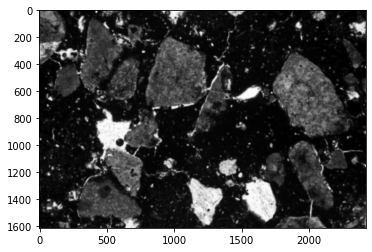

In [170]:
# Blurring/smoothing
# Gaussian filter from scipy.ndimage
img = scipy.ndimage.gaussian_filter(img_gray, sigma=3)

plt.imshow(img, cmap=plt.cm.gray)

In [171]:
################################################################################
# 4. segmentation

In [172]:
# fig, ax = try_all_threshold(img, figsize=(10, 10), verbose=False)
# plt.show()

In [173]:
# apply threshold: mean
im_th = threshold_mean(img)             # for inclusions, images taken in xp
#im_th = threshold_minimum(img)         # for voids calculation, images taken in ppl
#im_th = threshold_otsu(img)            # for inclusions, images taken in xp

In [174]:
# clean image
bw = closing(img > im_th)

# plt.imshow(bw, cmap=plt.cm.gray)
# plt.show()

In [175]:
# remove artifacts connected to image border
im_th = clear_border(bw)

# plt.imshow(im_th, cmap="gray")
# plt.show()

In [176]:
################################################################################
# 5. label

Number of objects found: 167


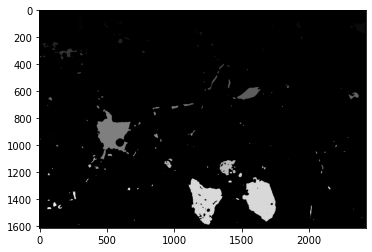

In [177]:
# label image regions    -   1
label_image, num_obj = label(im_th, return_num=True)
props = regionprops(label_image)
props_tb = regionprops_table(label_image, img, 
                             properties=['label', 'area', 'filled_area','perimeter', 'major_axis_length','minor_axis_length' ])
print("Number of objects found: %s" %num_obj)
plt.imshow(label_image, cmap="gray")
plt.show()

Number of objects found: 167


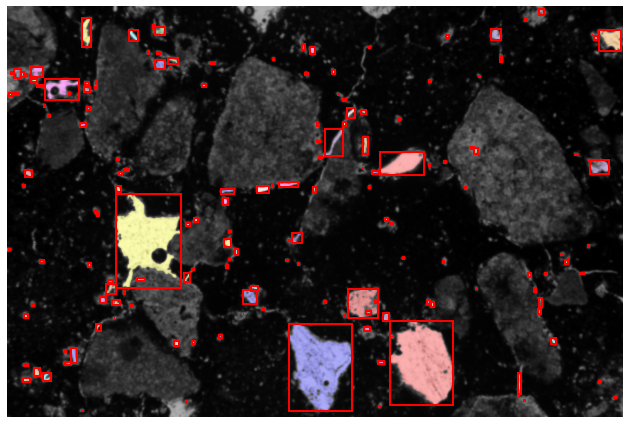

In [178]:
# Lable image  -  2

# to make the background transparent, pass the value of `bg_label`,
# and leave `bg_color` as `None` and `kind` as `overlay`
label_image2 , num_obj = label(im_th, return_num=True)
print("Number of objects found: %s" %num_obj)
props2 = regionprops(label_image2)
props_tb2 = regionprops_table(label_image2, img, 
                              properties=['label', 'area', 'filled_area','perimeter', 'major_axis_length','minor_axis_length' ])

image_label_overlay = label2rgb(label_image2, image=img, bg_label=0)
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)

for region in regionprops(label_image2):
    # take regions with large enough areas
    # if ((region.bbox[2]-region.bbox[0])>sizeTh and (region.bbox[3] - region.bbox[1])>sizeTh):               # insert Th value
        #    region.area >= 1500:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

ax.set_axis_off()
plt.tight_layout()
plt.show()

In [179]:
################################################################################
#Show largest regions location, image and edge

In [180]:
#Sort all found shapes by region size
sortRegions2 = [[(region.bbox[2]-region.bbox[0]) * (region.bbox[3] - region.bbox[1]),region.bbox] 
                for region in regionprops(label_image2) if
                ((region.bbox[2]-region.bbox[0])>5 and (region.bbox[3] - region.bbox[1])>5)]              # > 5 pixels
sortRegions2 = sorted(sortRegions2, reverse=True)

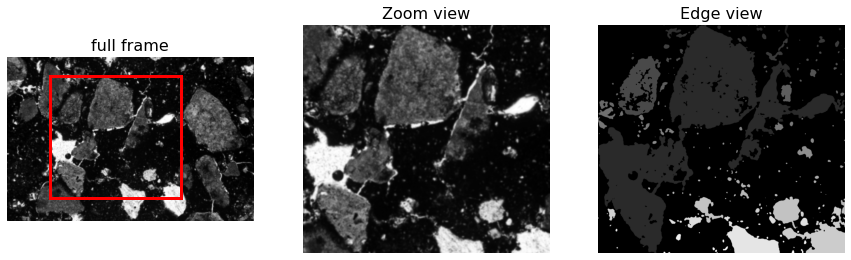

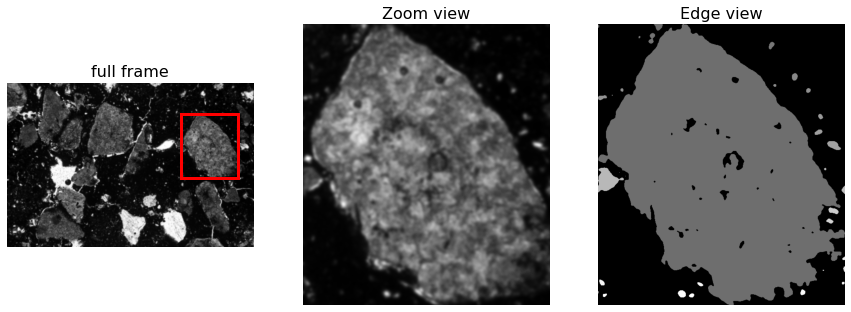

In [112]:
for region in sortRegions2[:2]:
    # Draw rectangle around segmented coins.
    minr, minc, maxr, maxc = region[1]
    fig, ax = plt.subplots(1,3,figsize=(15,6))
    ax[0].imshow(img, cmap=plt.cm.gray)
    ax[0].set_title('full frame', fontsize=16)
    ax[0].axis('off')
    rect = mpatches.Rectangle((minc, minr),
                          maxc - minc,
                          maxr - minr,
                          fill=False,
                          edgecolor='red',
                          linewidth=3)
    ax[0].add_patch(rect)
    
    ax[1].imshow(img[minr:maxr,minc:maxc],cmap='gray')
    ax[1].set_title('Zoom view', fontsize=16)
    ax[1].axis("off")

    ax[2].imshow(label_image[minr:maxr,minc:maxc],cmap='gray')
    ax[2].set_title('Edge view', fontsize=16)
    ax[2].axis("off")
    plt.show()

In [181]:
################################################################################
# 6. Conversion rate

In [182]:
height, width, color = img.shape

ValueError: ignored

In [183]:
width, height = img_gray.shape

In [184]:
width

1613

In [185]:
mm_per_pixels = 5/width     # inserire lunghezza in mm dell'immagine
pixels_per_mm = width/5     # inserire lunghezza in mm dell'immagine

In [186]:
d = {'mm_per_pixels': [mm_per_pixels],
     'pixels_per_mm': [pixels_per_mm]}

pd.DataFrame(d)

,mm_per_pixels,pixels_per_mm
0,0.0031,322.6


In [187]:
################################################################################
# 7. Measure properties of labeled image regions and return them as table

In [188]:
props = regionprops(label_image)           # or label_image2

In [189]:
len(props)

167

In [190]:
props_tb = regionprops_table(label_image, img, 
                             properties=['label', 'area', 'filled_area','perimeter', 'major_axis_length','minor_axis_length'])

In [191]:
data = pd.DataFrame(props_tb)
data['aspect ratio'] = data['major_axis_length']/data['minor_axis_length']
data['roundness'] = data['minor_axis_length']/data['major_axis_length']

In [192]:
sort_by_area =   pd.DataFrame(data.sort_values('area', ascending=False))
# sort_by_area[sort_by_area['area'] > 1500].head()    # table with areas > X pixels (here)
# round(sort_by_area[sort_by_area['area'] > 1000],2).head()    # table with areas > X (here 1000 pixels)
round(sort_by_area,3).head()

,label,area,filled_area,perimeter,major_axis_length,minor_axis_length,aspect ratio,roundness
140,141,48922,49157,1239.426,311.530,206.586,1.508,0.663
141,142,44844,46605,1888.234,313.671,221.855,1.414,0.707
82,83,42747,42747,1703.859,286.712,241.910,1.185,0.844
60,61,8450,8450,465.973,168.711,66.111,2.552,0.392
120,121,7621,7898,762.879,122.083,103.224,1.183,0.846


In [193]:
# Conversion to mm:
data_mm =  pd.DataFrame(props_tb)
data_mm['aspect ratio'] = data_mm['major_axis_length']/data_mm['minor_axis_length']
data_mm['roundness'] = data_mm['minor_axis_length']/data_mm['major_axis_length']

#data_mm = data
data_mm.loc[:, data_mm.columns != 'label']*mm_per_pixels
data_mm[["area","filled_area"]] = mm_per_pixels * data_mm[["area","filled_area"]]  # area = *mm_per_pixels^2

In [194]:
sort_by_area_mm =   pd.DataFrame(data_mm.sort_values('area', ascending=False))
round(sort_by_area_mm,3).head()

,label,area,filled_area,perimeter,major_axis_length,minor_axis_length,aspect ratio,roundness
140,141,151.649,152.378,1239.426,311.530,206.586,1.508,0.663
141,142,139.008,144.467,1888.234,313.671,221.855,1.414,0.707
82,83,132.508,132.508,1703.859,286.712,241.910,1.185,0.844
60,61,26.193,26.193,465.973,168.711,66.111,2.552,0.392
120,121,23.624,24.482,762.879,122.083,103.224,1.183,0.846


In [195]:
round(min(data_mm.area),3), round(max(data_mm.area),3)    # min and max area in mm

(0.006, 151.649)

In [196]:
round(min(data.area),3), round(max(data.area),3)          # min and max area in pixels

(2, 48922)

In [197]:
# summary of data:
length = len(regionprops(label_image))                # particles count
tot_area = data["filled_area"].sum()                           # total particle area in pixels
tot_filled_area = data["filled_area"].sum()  * 100 /  (width * height)                                             # area fraction in percentage 
tot_filled_area_x100 = data["filled_area"].sum()  * 100 /  (width * height) 

# mean of all parameters:
mean_area = data["area"].mean()
mean_filled_area = data["filled_area"].mean()
mean_perimeter = data["perimeter"].mean()
mean_major_axis_length = data["major_axis_length"].mean()
mean_minor_axis_length = data["minor_axis_length"].mean()    


In [198]:
data_df = {'number of particles': [length],
           'tot area %': [tot_filled_area_x100],
           'mean area': [mean_filled_area],
           'mean major axis': [mean_major_axis_length],
           'mean minor axis': [mean_minor_axis_length]
           }

print("Summary of data (pixels):")
data_df = pd.DataFrame (data_df, columns = ['number of particles','tot area %','mean area', 'mean major axis','mean minor axis'])
print (round(data_df))

Summary of data (pixels):
   number of particles  tot area %  mean area  mean major axis  mean minor axis
0                  167         5.0     1157.0             28.0             15.0


In [199]:
# summary of data in mm:
length_mm = len(regionprops(label_image))                # particles count
data["filled_area"].sum() * mm_per_pixels * mm_per_pixels                          # total particle area in pixels
tot_filled_area_x100_mm = data["filled_area"].sum()  * 100 /  (width * height)                                             # area fraction in percentage 

# mean of all parameters:
data["area"].mean() * mm_per_pixels  * mm_per_pixels
mean_filled_area_mm = data["filled_area"].mean()  * mm_per_pixels  * mm_per_pixels
data["perimeter"].mean()  * mm_per_pixels 
mean_major_axis_length_mm = data["major_axis_length"].mean()  * mm_per_pixels
mean_minor_axis_length_mm = data["minor_axis_length"].mean() * mm_per_pixels

0.04525415379560821

In [200]:
data_df = {'number of particles': [length_mm],
           'tot area %': [tot_filled_area_x100_mm],
           'mean area': [mean_filled_area_mm],
           'mean major axis': [mean_major_axis_length_mm],
           'mean minor axis': [mean_minor_axis_length_mm]
           }

print("Summary of data (pixels):")
data_df = pd.DataFrame (data_df, columns = ['number of particles','tot area %','mean area', 'mean major axis','mean minor axis'])
print (round(data_df))

Summary of data (pixels):
   number of particles  tot area %  mean area  mean major axis  mean minor axis
0                  167         5.0     1157.0             28.0             15.0


In [80]:
from skimage.filters import threshold_otsu, threshold_mean, threshold_isodata, threshold_li, threshold_local
from skimage.filters import threshold_minimum, threshold_multiotsu, threshold_niblack, threshold_otsu
from skimage.filters import threshold_sauvola, threshold_triangle, threshold_yen

In [81]:
# apply threshold: all
otsu = threshold_otsu(img)
mean = threshold_mean(img)
isodata = threshold_isodata(img)
li = threshold_li(img)
minimum = threshold_minimum(img)
multiotsu = threshold_multiotsu(img)
niblack = threshold_niblack(img)
sauvola = threshold_sauvola(img)
triangle = threshold_triangle(img)
yen = threshold_yen(img)

In [82]:
# clean image
bw_otsu = closing(img > otsu)
bw_mean = closing(img > mean)
bw_isodata = closing(img > isodata)
bw_li = closing(img > li)
bw_minimum = closing(img > minimum)
bw_niblack = closing(img > niblack)
bw_sauvola = closing(img > sauvola)
bw_triangle = closing(img > triangle)
bw_yen = closing(img > yen)

In [83]:
# remove artifacts connected to image border
im_th_otsu = clear_border(bw_otsu)
im_th_mean = clear_border(bw_mean)
im_th_isodata = clear_border(bw_isodata)
im_th_li = clear_border(bw_li)
im_th_minimum = clear_border(bw_minimum)
im_th_niblack = clear_border(bw_niblack)
im_th_sauvola = clear_border(bw_sauvola)
im_th_triangle = clear_border(bw_triangle)
im_th_yen = clear_border(bw_yen)

In [ ]:
# label image regions    -   1
# to make the background transparent, pass the value of `bg_label`,
# and leave `bg_color` as `None` and `kind` as `overlay`
label_image_otsu, num_obj = label(im_th_otsu, return_num=True)
print("otsu: Number of objects found: %s" %num_obj)
image_label_overlay = label2rgb(label_image_otsu, image=img, bg_label=0)
fig, ax = plt.subplots(figsize=(10/1.5, 6/1.5))
ax.imshow(image_label_overlay)
ax.set_axis_off()
plt.tight_layout()
plt.show()

label_image_mean, num_obj = label(im_th_mean, return_num=True)
print("mean: Number of objects found: %s" %num_obj)
image_label_overlay = label2rgb(label_image_mean, image=img, bg_label=0)
fig, ax = plt.subplots(figsize=(10/1.5, 6/1.5))
ax.imshow(image_label_overlay)
ax.set_axis_off()
plt.tight_layout()
plt.show()

label_image_isodata, num_obj = label(im_th_isodata, return_num=True)
print("isodata: Number of objects found: %s" %num_obj)
image_label_overlay = label2rgb(label_image_isodata, image=img, bg_label=0)
fig, ax = plt.subplots(figsize=(10/1.5, 6/1.5))
ax.imshow(image_label_overlay)
ax.set_axis_off()
plt.tight_layout()
plt.show()

label_image_li, num_obj = label(im_th_li, return_num=True)
print("li: Number of objects found: %s" %num_obj)
image_label_overlay = label2rgb(label_image_li, image=img, bg_label=0)
fig, ax = plt.subplots(figsize=(10/1.5, 6/1.5))
ax.imshow(image_label_overlay)
ax.set_axis_off()
plt.tight_layout()
plt.show()

label_image_minimum, num_obj = label(im_th_minimum, return_num=True)
print("min: Number of objects found: %s" %num_obj)
image_label_overlay = label2rgb(label_image_minimum, image=img, bg_label=0)
fig, ax = plt.subplots(figsize=(10/1.5, 6/1.5))
ax.imshow(image_label_overlay)
ax.set_axis_off()
plt.tight_layout()
plt.show()

label_image_niblack, num_obj = label(im_th_niblack, return_num=True)
print("niblack: Number of objects found: %s" %num_obj)
image_label_overlay = label2rgb(label_image_niblack, image=img, bg_label=0)
fig, ax = plt.subplots(figsize=(10/1.5, 6/1.5))
ax.imshow(image_label_overlay)
ax.set_axis_off()
plt.tight_layout()
plt.show()

label_image_sauvola, num_obj = label(im_th_sauvola, return_num=True)
print("sauvola: Number of objects found: %s" %num_obj)
image_label_overlay = label2rgb(label_image_sauvola, image=img, bg_label=0)
fig, ax = plt.subplots(figsize=(10/1.5, 6/1.5))
ax.imshow(image_label_overlay)
ax.set_axis_off()
plt.tight_layout()
plt.show()

label_image_triangle, num_obj = label(im_th_triangle, return_num=True)
print("triangle: Number of objects found: %s" %num_obj)
image_label_overlay = label2rgb(label_image_triangle, image=img, bg_label=0)
fig, ax = plt.subplots(figsize=(10/1.5, 6/1.5))
ax.imshow(image_label_overlay)
ax.set_axis_off()
plt.tight_layout()
plt.show()

label_image_yen, num_obj = label(im_th_yen, return_num=True)
print("yen: Number of objects found: %s" %num_obj)
image_label_overlay = label2rgb(label_image_yen, image=img, bg_label=0)
fig, ax = plt.subplots(figsize=(10/1.5, 6/1.5))
ax.imshow(image_label_overlay)
ax.set_axis_off()
plt.tight_layout()
plt.show()


In [139]:
len_li = len(regionprops(label_image_li))
len_otsu = len(regionprops(label_image_otsu))
len_mean = len(regionprops(label_image_mean))
len_isodata = len(regionprops(label_image_isodata))
len_minimum = len(regionprops(label_image_minimum))
len_niblack = len(regionprops(label_image_niblack))
len_sauvola = len(regionprops(label_image_sauvola))
len_triangle = len(regionprops(label_image_triangle))
len_yen = len(regionprops(label_image_yen))


data = {'type':  ['li', 'otsu', 'mean', 'isodata', 'minimum', 'niblack', 'sauvola', 'triangle', 'yen'],
        'Number of objects found:': [len_li, len_otsu, len_mean, len_isodata, len_minimum, len_niblack, len_sauvola, len_triangle, len_yen]
        }
df = pd.DataFrame (data, columns = ['type','Number of objects found:'])
print (df)

       type  Number of objects found:
0        li                       628
1      otsu                       822
2      mean                       628
3   isodata                       808
4   minimum                       167
5   niblack                      2985
6   sauvola                       491
7  triangle                       753
8       yen                       587
